# Classification avec les modèles d'OpenAI

Ce notebook vise à évaluer les performances des modèles d'OpenAI sur une tache de classification de texte. Nous allons effectuer une classification parmi 10 classes en utilisant respectivement :
- Zero-Shot Evaluation
- Few-Shot Evaluation
- Full Training

In [1]:
MODEL_TO_EVALUATE = ["davinci-002", "gpt-3.5-turbo-1106"]
CONTEXT = "Tu es un classificateur de texte dont l'objectif est de classifier des textes dans un l'un de ces 10 catégories :\n{}\n\n Afin de mieux mesurer tes performances, tu dois répondre avec les 5 catégories les plus probables ordonnées par probabilité que le texte y appartienne et séparées par des virgules. Tu ne dois répondre qu'avec les 5 catégorie les plus probables pour ce texte, séparées par des virgules, sans aucun commentaire.\nExemple :\n- user: Ceci est un texte d'exemple parlant de tennis.\n- you: Sport, Health, Food, Culture, World\n"

In [2]:
# ---------------------------- PREPARING NOTEBOOK ---------------------------- #
# Autoreload
%load_ext autoreload
%autoreload 2

# Random seed
import numpy as np
np.random.seed(42)

# External modules
import os
from IPython.display import display, Markdown, Latex, clear_output
from tqdm import notebook as tqdm

# Set global log level
import logging
logging.basicConfig(level=logging.INFO)
os.environ['TOKENIZERS_PARALLELISM'] = 'false'

# Define PWD as the current git repository
import git
repo = git.Repo('.', search_parent_directories=True)
pwd = repo.working_dir
os.chdir(pwd) 

## Data Preparation

In [3]:
# ------------------------------ LOADING DATASET ----------------------------- #
import pandas as pd

dataset_path = os.path.join(pwd, "results", "topic_classification", "DataPreparation")

train_dataset = pd.read_csv(os.path.join(dataset_path, "train.csv"))
test_dataset = pd.read_csv(os.path.join(dataset_path, "test.csv"))

# Fill Context
CONTEXT = CONTEXT.format(
    "- " + ",\n- ".join(train_dataset["topic"].unique()) + ".", train_dataset["text"]
)
display(Markdown(CONTEXT))

Tu es un classificateur de texte dont l'objectif est de classifier des textes dans un l'un de ces 10 catégories :
- Travel,
- Science,
- Music,
- Culture,
- Health,
- World,
- Sport,
- Business,
- Politics,
- Technology,
- Food.

 Afin de mieux mesurer tes performances, tu dois répondre avec les 5 catégories les plus probables ordonnées par probabilité que le texte y appartienne et séparées par des virgules. Tu ne dois répondre qu'avec les 5 catégorie les plus probables pour ce texte, séparées par des virgules, sans aucun commentaire.
Exemple :
- user: Ceci est un texte d'exemple parlant de tennis.
- you: Sport, Health, Food, Culture, World


## Connexion à l'API

In [4]:
import openai

# Try to read saved key
try:
    with open(os.path.join(pwd, ".openai_key"), "r") as key_file:
        key = key_file.read()
        openai.api_key = key
except FileNotFoundError:
    # Ask for key
    key = input("Please enter your OpenAI API key:")
    openai.api_key = key
    # Save key
    with open(os.path.join(pwd, ".openai_key"), "w") as key_file:
        key_file.write(key)

## Zero-Shot Evaluation

In [9]:
import openai
import re

model_predictions = {}
for model in MODEL_TO_EVALUATE:
    # Try to load already computed predictions
    file_name = "ZeroShot_" + model
    path = os.path.join(
        pwd,
        "results",
        "topic_classification",
        "OpenAiTopicClassification",
        f"{file_name}_predictions.csv",
    )
    # Create folder if needed
    if not os.path.exists(os.path.dirname(path)):
        os.makedirs(os.path.dirname(path))
    try:
        model_predictions[file_name] = {"predictions": pd.read_csv(path, sep=";")}
    except:
        # Compute predictions
        predictions = []
        for text in tqdm.tqdm(test_dataset["text"]):
            try:
                if "gpt" in model:
                    response = openai.ChatCompletion.create(
                        model=model,
                        messages=[
                            {"role": "system", "content": CONTEXT},
                            {"role": "user", "content": text},
                        ],
                        temperature=0,
                        max_tokens=20,
                    )
                    prediction = response.choices[0]["message"]["content"].strip()
                else:
                    response = openai.Completion.create(
                        engine=model,
                        prompt=f"# Contexte :\n{CONTEXT}\n\n# Texte :\n{text}\n\n# Catégories :\n",
                        temperature=0,
                        max_tokens=20,
                    )
                    prediction = response.choices[0].text.strip()
            except Exception as e:
                print(e)
                print(f"Error with text: {text}")
                print("Skipping...")
                predictions.append("Error")
                continue

            predictions.append(prediction)
        # Save predictions
        model_predictions[file_name] = {"predictions": pd.DataFrame(predictions)}
        model_predictions[file_name]["predictions"].to_csv(path, index=False, sep=";")

In [10]:
metrics_dict = {}
for model in MODEL_TO_EVALUATE:
    file_name = "ZeroShot_" + model
    path = os.path.join(
        pwd,
        "results",
        "OpenAiTopicClassification",
        f"{file_name}_predictions.csv",
    )
    predictions = pd.read_csv(path, sep=";").iloc[:, 0]
    predictions_list = []
    for p in predictions.str.extractall(r"(\b\w+\b)").iterrows():
        if p[0][0] > len(predictions_list) - 1:
            predictions_list.append([p[1][0]])
        else:
            predictions_list[p[0][0]].append(p[1][0])
    labels = pd.Series(predictions_list, name="labels").apply(
        lambda row: [word for word in row if word in train_dataset["topic"].unique()][
            :5
        ]
    )
    result = labels.to_frame().join(test_dataset["topic"].rename("label"))

    metrics_dict[file_name] = result

,accuracy@1,accuracy@3,accuracy@5
World,0.000000,0.056452,0.072581
Business,0.000000,0.000000,0.035714
Food,0.000000,0.000000,0.023810
Culture,0.003484,0.017422,0.832753
Science,0.007092,0.744681,0.751773
Health,0.039823,0.088496,0.778761
Technology,0.050633,0.050633,0.063291
Music,0.054422,0.884354,0.891156
Politics,0.131148,0.131148,0.131148
Sport,0.374552,0.413978,0.415771


,accuracy,precision,recall,f1
ZeroShot_davinci-002,0.228088,0.228088,0.228088,0.228088


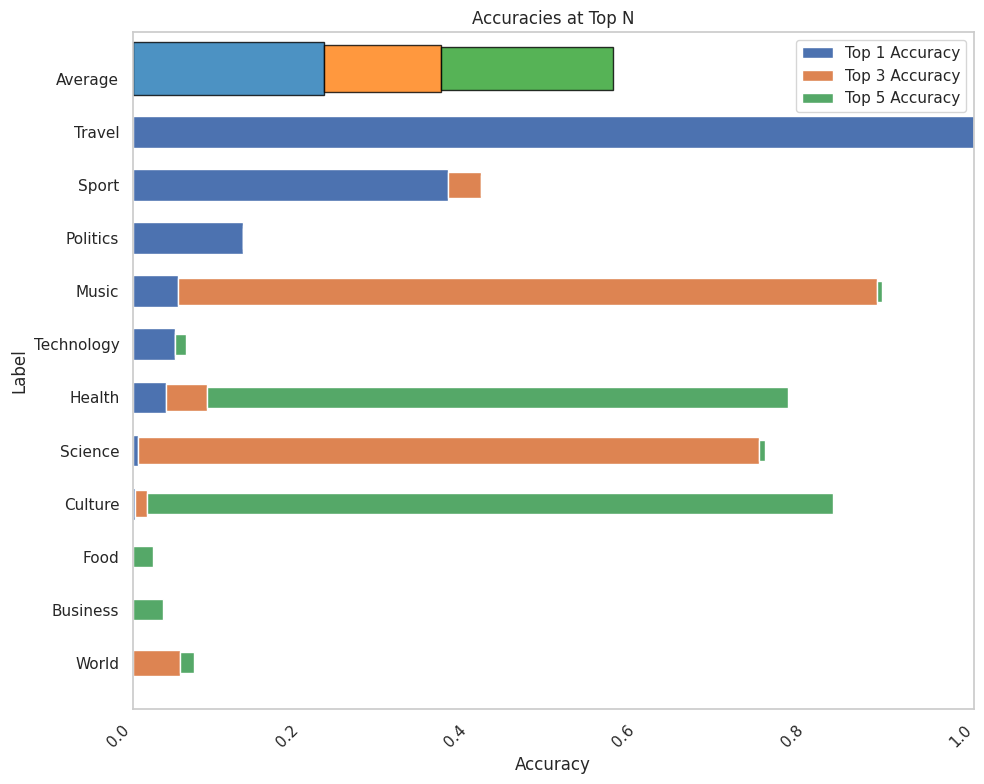

,accuracy@1,accuracy@3,accuracy@5
Business,0.142857,0.821429,1.000000
Science,0.248227,0.468085,0.574468
World,0.274194,0.983871,1.000000
Technology,0.569620,0.848101,0.936709
Food,0.571429,0.833333,0.880952
Culture,0.616725,0.926829,0.965157
Travel,0.639594,0.934010,0.979695
Health,0.654867,0.907080,0.960177
Music,0.673469,0.952381,0.972789
Sport,0.822581,0.931900,0.958781


,accuracy,precision,recall,f1
ZeroShot_gpt-3.5-turbo-1106,0.64736,0.64736,0.64736,0.64736


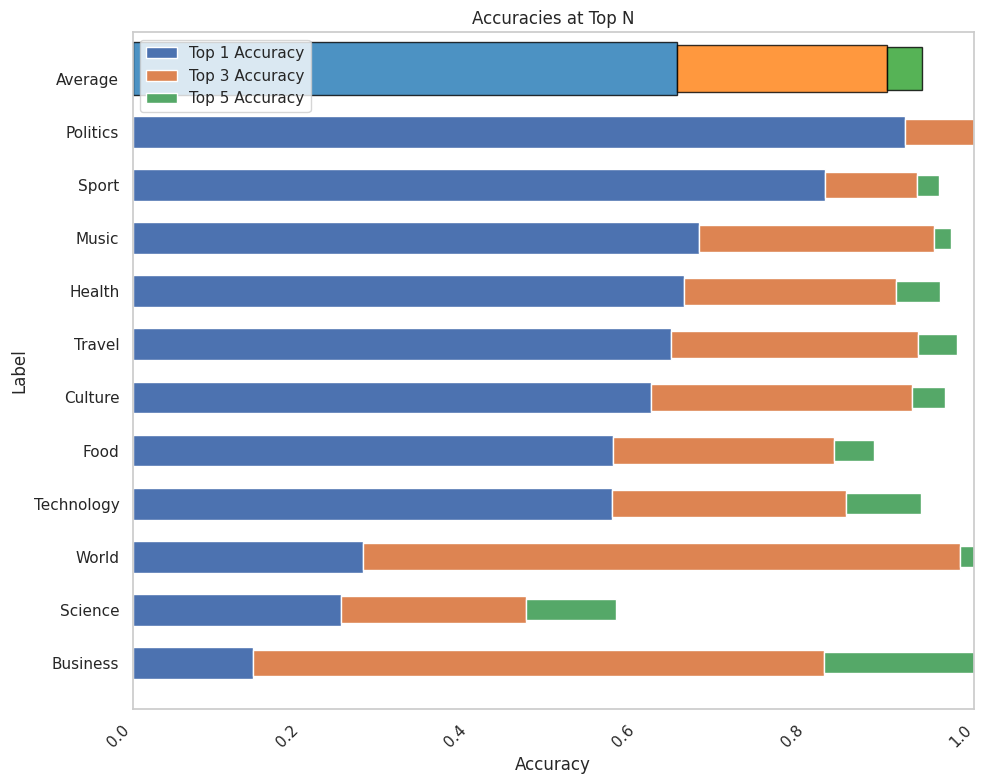

In [16]:
import pandas as pd
from sklearn.metrics import precision_score, recall_score, f1_score
import matplotlib.pyplot as plt
import seaborn as sns


for key in metrics_dict.keys():
    result = metrics_dict[key]

    def is_in_top_n(label: str, n: int = 1):
        return result[result["label"] == label]["labels"].apply(
            lambda x: label in x[:n]
        )

    metrics = {}
    for label in result["label"].unique():
        metrics[label] = {
            "accuracy@1": is_in_top_n(label, 1).mean(),
            "accuracy@3": is_in_top_n(label, 3).mean(),
            "accuracy@5": is_in_top_n(label, 5).mean(),
        }
    metrics["Average"] = {
        "accuracy@1": result.apply(
            lambda x: x["label"] in x["labels"][:1], axis=1
        ).mean(),
        "accuracy@3": result.apply(
            lambda x: x["label"] in x["labels"][:3], axis=1
        ).mean(),
        "accuracy@5": result.apply(
            lambda x: x["label"] in x["labels"][:5], axis=1
        ).mean(),
    }

    metrics = pd.DataFrame(metrics).T
    metrics = metrics.sort_values("accuracy@1", ascending=True)

    # Move Average row to the top
    metrics = pd.concat([metrics.drop("Average"), metrics.loc[["Average"]]])

    # Save metrics
    path = os.path.join(
        pwd,
        "results",
        "topic_classification",
        "OpenAiTopicClassification",
        f"{key}_metrics.csv",
    )
    if not os.path.exists(os.path.dirname(path)):
        os.makedirs(os.path.dirname(path))
    metrics.to_csv(path)

    display(metrics)

    # Calculate precision, recall and f1-score
    precision = precision_score(
        result["label"].tolist(),
        result["labels"].apply(lambda x: x[0] if len(x) else "").tolist(),
        average="micro",
    )
    recall = recall_score(
        result["label"].tolist(),
        result["labels"].apply(lambda x: x[0] if len(x) else "").tolist(),
        average="micro",
    )
    f1 = f1_score(
        result["label"].tolist(),
        result["labels"].apply(lambda x: x[0] if len(x) else "").tolist(),
        average="micro",
    )
    classification_metrics = pd.DataFrame(
        {
            "accuracy": [metrics.loc["Average", "accuracy@1"]],
            "precision": [precision],
            "recall": [recall],
            "f1": [f1],
        },
        index=[key],
    )

    # Save metrics
    path = os.path.join(
        pwd,
        "results",
        "topic_classification",
        "OpenAiTopicClassification",
        f"{key}_classification_metrics.csv",
    )
    if not os.path.exists(os.path.dirname(path)):
        os.makedirs(os.path.dirname(path))
    classification_metrics.to_csv(path)

    display(classification_metrics)

    # Assurez-vous que le DataFrame 'metrics' est déjà créé et trié par 'accuracy@1'
    # metrics.sort_values("accuracy@1", ascending=False)

    # Réinitialiser l'index pour pouvoir utiliser la colonne des labels dans le graphique
    metrics.reset_index(inplace=True)
    metrics.rename(columns={"index": "Label"}, inplace=True)

    # Nous utilisons seaborn pour un style de graphique amélioré
    sns.set_theme(style="whitegrid")

    # La taille du graphique peut être ajustée pour mieux s'adapter à vos données
    plt.figure(figsize=(10, 8))

    # Création d'un graphique à barres empilées
    # bottom paramètre spécifie où la barre commence, donc nous empilons en additionnant la précision précédente
    plt.barh(
        metrics["Label"], metrics["accuracy@1"], label="Top 1 Accuracy", height=0.6
    )
    plt.barh(
        metrics["Label"],
        metrics["accuracy@3"] - metrics["accuracy@1"],
        label="Top 3 Accuracy",
        height=0.5,
        left=metrics["accuracy@1"],
    )
    plt.barh(
        metrics["Label"],
        metrics["accuracy@5"] - metrics["accuracy@3"],
        label="Top 5 Accuracy",
        height=0.4,
        left=metrics["accuracy@3"],
    )

    # Titre du graphique et étiquettes des axes
    plt.title("Accuracies at Top N")
    plt.xlabel("Accuracy")
    plt.ylabel("Label")

    # Rotation des étiquettes sur l'axe des x pour une meilleure lisibilité si nécessaire
    plt.xticks(rotation=45, ha="right")

    # Ajout d'une légende
    plt.legend()

    # Utilisez plt.tight_layout() si vous constatez que les étiquettes sont coupées dans la sortie finale
    plt.tight_layout()

    # Remove grid
    plt.grid(False)

    # Give specific color to first bar
    plt.gca().get_children()[11].set(
        color="#1f77b4", alpha=0.8, edgecolor="black", height=1
    )
    plt.gca().get_children()[23].set(
        color="#ff7f0e", alpha=0.8, edgecolor="black", height=0.9
    )
    plt.gca().get_children()[35].set(
        color="#2ca02c", alpha=0.8, edgecolor="black", height=0.8
    )

    # Affichage du graphique
    plt.show()